In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torch.jit
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 16

trainset = torchvision.datasets.ImageFolder(root='cat-vs-dog-data/training_set/training_set', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='cat-vs-dog-data/test_set/test_set/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('cat', 'dog')

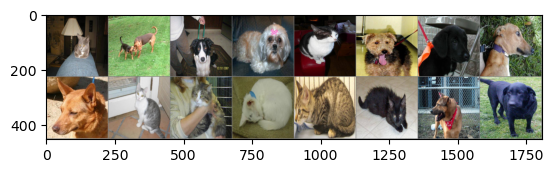

cat   dog   dog   dog   cat   dog   dog   dog   dog   cat   cat   cat   cat   cat   dog   dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(73728, 540)
        # self.fc1 = nn.Linear(128*((((224-5+1)//2-5+1)//2-5+1)//2), 540)
        self.fc2 = nn.Linear(540, 540)
        self.fc3 = nn.Linear(540, 120)
        self.fc4 = nn.Linear(120, 120)
        self.fc5 = nn.Linear(120, 84)
        self.fc6 = nn.Linear(84, 84)
        self.fc7 = nn.Linear(84, 2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x


In [5]:
def totParamCounter(net: nn.Module) -> int:
    return sum(param.numel() for param in net.parameters())

In [7]:
device = torch.device('mps')
net = torch.load('models/torchmodels/model3-kindabig.pth').to(device=device) # I think this is good for M1 macs
print(sum(param.numel() for param in net.parameters()))
print(net)

40461338
Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=540, bias=True)
  (fc2): Linear(in_features=540, out_features=540, bias=True)
  (fc3): Linear(in_features=540, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=120, bias=True)
  (fc5): Linear(in_features=120, out_features=84, bias=True)
  (fc6): Linear(in_features=84, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 0.01)

In [ ]:
print_frequency = 100

for epoch in range(50):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs, labels= inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_frequency == -1 % print_frequency):
            tqdm.write(f'[{epoch}, {i}] loss: {running_loss / print_frequency:.8f}') # like print but doesn't mess up progress bar
            # print(f'[{epoch}, {i}] loss: {running_loss / print_frequency:.3f}')
            running_loss = 0
    torch.save(net, 'models/torchmodels/model3-mid-train-checkpoint.pth')

print('Finished Training')

torch.save(net, 'models/torchmodels/model3-kindabig.pth')

In [ ]:
epoch = 0
while True:  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs, labels= inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / 4000:.3f}')
    torch.save(net, 'models/torchmodels/model3-mid-train-checkpoint.pth')
    epoch += 1

    if (running_loss / 4000 < 0.0001):
        break

print('Finished Training')

torch.save(net, 'models/torchmodels/model3-kindabig.pth')

In [ ]:
PATH = 'models/torchmodels/'+input()+'.pth'
torch.save(net, PATH)

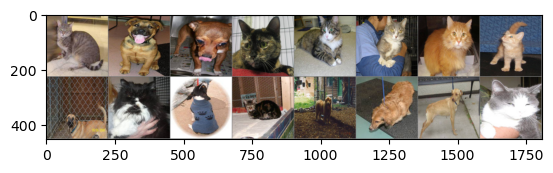

GroundTruth:  cat   dog   dog   cat   cat   cat   cat   cat   dog   cat   dog   cat   dog   dog   dog   cat  


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
images, labels = images.to(device), labels.to(device)

outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   dog   cat   cat   cat   cat   cat   dog   cat   cat   dog   cat   cat   cat   dog   cat  


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

Accuracy of the network on the 1000 test images: 70 %


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
incorrect_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)


        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            else:
                incorrect_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: cat   is 67.5 %
Accuracy for class: dog   is 73.1 %


In [13]:
classes = ['cat', 'dog']
cm = [[correct_pred['cat'], incorrect_pred['cat']], [incorrect_pred['dog'], correct_pred['dog']]]

Text(0.5, 9.061174279463687, 'Predicted label')

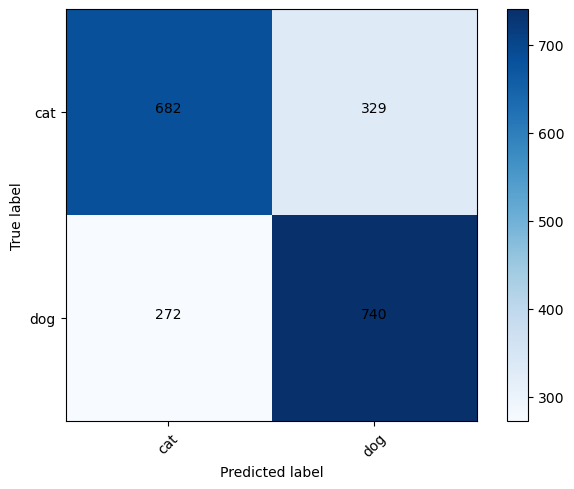

In [14]:
import itertools
import numpy as np
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = sum(sum(i for i in j) for j in cm) / 2.
for i, j in itertools.product(range(len(cm)), range(len(cm[0]))):
    plt.text(j, i, str(cm[i][j]),
        horizontalalignment="center",
        color="white" if cm[i][j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')